In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

### Read data and parse date column

In [2]:
parse_date = lambda val : datetime.strptime(val, '%y%m%d%H')
data = pd.read_csv('subsetTrain.csv', parse_dates = ['hour'], date_parser = parse_date, dtype = {'hour':np.dtype(int)})

In [3]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,2014-10-21,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [4]:
data.shape

(4999999, 24)

Due to some technical constraints we will be working with a sample of 5M rows. The total number of rows in the data is ~400M (train set)

We will interpret each row as an add exposure and use the click column to calculate the CRT. For each hour in the day the CRT would be the sum of ones (clicks) devide by the number of total exposures

### 1. Calculating CTR over time

In [5]:
data_agg = data.groupby(['hour', 'click']).size().unstack() 

In [6]:
data_agg.head()

click,0,1
hour,,
2014-10-21 00:00:00,98214,20792
2014-10-21 01:00:00,113569,23873
2014-10-21 02:00:00,176206,31265
2014-10-21 03:00:00,160525,32830
2014-10-21 04:00:00,224685,40026


In [7]:
CTR_data = pd.DataFrame()
CTR_data['Click_1'] = data_agg.get(1)
CTR_data['Click_0'] = data_agg.get(0)
CTR_data['Total_Ad_Exposures'] = CTR_data.Click_1 + CTR_data.Click_0
CTR_data['CTR'] =  CTR_data.Click_1/CTR_data.Total_Ad_Exposures

In [8]:
CTR_data.reset_index(inplace = True)
CTR_data = CTR_data.rename(columns = {'hour': 'date'})

CTR_data['hour'] = CTR_data.date.dt.hour

Reading the above data: 
* Click_1 stands for the number of clicks during that hour (click = 1)
* Click_0 stands for the number of ad exposures without clicks during that hour (click =0)
* Total_Ad_Exposures is the number of total ad exposures in that hour
* CTR as per definition is the number of clicks devided by the number of impressions

#### Plotting the resulting time series

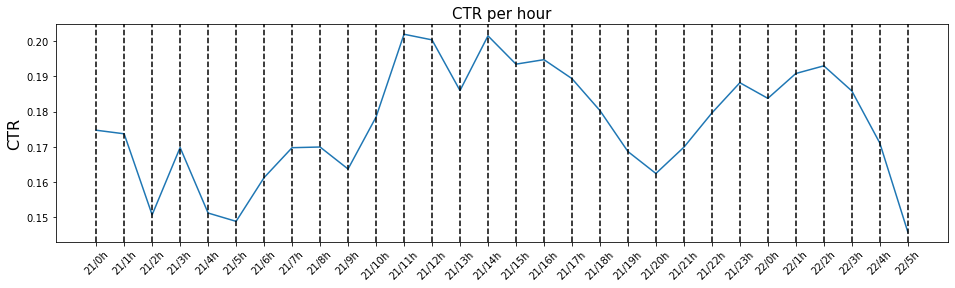

In [9]:
plt.figure(figsize = (16,4))
plt.plot(CTR_data.CTR)
plt.title('CTR per hour', fontsize = 15)
plt.ylabel('CTR', fontsize = 16)
plt.xticks(rotation=45)
for date in CTR_data.date.values.flatten():
    plt.axvline((str(pd.to_datetime(date).day) + '/'+ str(pd.to_datetime(date).hour) + 'h'), color ='k', linestyle = '--',)
    


On the x axis we can see the day and corresponding hour. For example 21/2h whould be  2AM on 22nd of the observed month. From the plot above we can see that we have peeks during some hours of the day. In the early hours of the day between 2 and 5 it would be logical not to have a high CTR.

### 2. Outlier detection using MA

Per definition, a data point is considered an outlier if it's more than 1.5 std from its calculated MA. 
#### Theory: 
- A moving average is a form of a convolution often used in time series analysis to smooth out noise in data by replacing a data point with the average of neighboring values in a moving window. A moving average is essentially a low-pass filter because it removes short-term fluctuations to highlight a deeper underlying trend. [source](https://waterprogramming.wordpress.com/2018/09/04/implementation-of-the-moving-average-filter-using-convolution/)

#### Implementation:
We will be using a discrete linear convolution to calculate the moving average 

In [10]:
# Calculate moving average
data_ = CTR_data.CTR.values
data_ = data_.flatten()
window = 2
# vect - moving average signal of length w and amplitude 1/w
vect = np.ones(int(window))/float(window)
rolling_mean = np.convolve(data_,vect,'same') 

#calculate std and residuals
df = CTR_data[['CTR']]
df['rolling_mean'] = rolling_mean
df['residual'] = df.iloc[:,0] - rolling_mean
std_resid = np.std(df.residual)
df['pos_std_1.5'] = df.rolling_mean + 1.5*std_resid
df['neg_std_1.5'] = df.rolling_mean - 1.5*std_resid


In [11]:
np.ones(int(window))/float(window)

array([0.5, 0.5])

In [12]:
df

,CTR,rolling_mean,residual,pos_std_1.5,neg_std_1.5
0,0.174714,0.087357,0.087357,0.112644,0.062070
1,0.173695,0.174204,-0.000509,0.199491,0.148918
2,0.150696,0.162195,-0.011500,0.187482,0.136909
3,0.169791,0.160244,0.009548,0.185530,0.134957
4,0.151206,0.160499,-0.009292,0.185786,0.135212
5,0.148845,0.150026,-0.001181,0.175312,0.124739
6,0.161259,0.155052,0.006207,0.180338,0.129765
7,0.169752,0.165506,0.004247,0.190792,0.140219
8,0.169945,0.169848,0.000096,0.195135,0.144562
9,0.163704,0.166824,-0.003120,0.192111,0.141538


### 3. Creating the plot

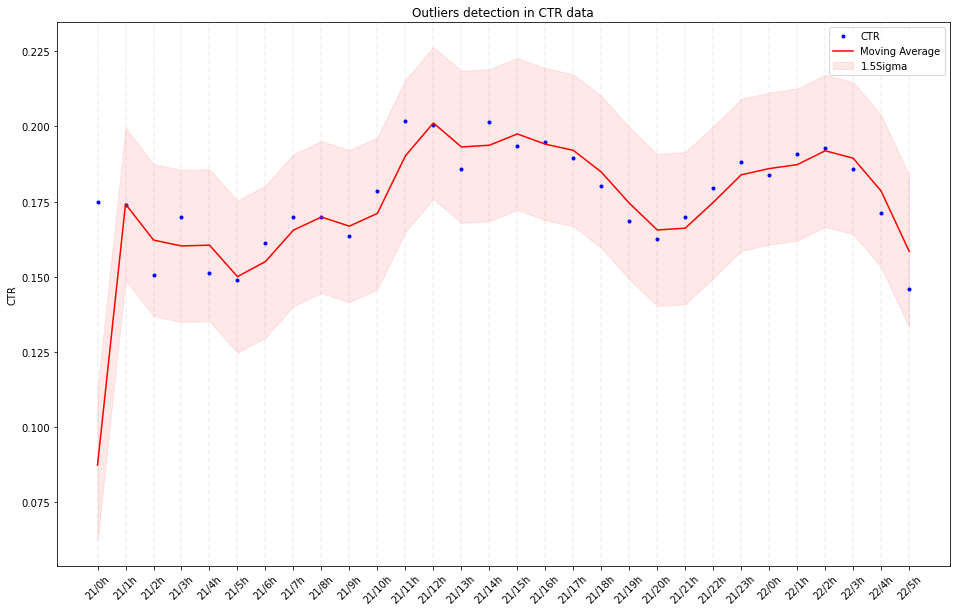

In [13]:

plt.figure(figsize = (16,10))
plt.plot(df.iloc[:,0],'b.',label='CTR')
plt.plot(df.rolling_mean,'r',label='Moving Average')
plt.xticks(rotation=45)
# this would be the +-1.5std band. A datapoint that falls outside the band would be an outlier
plt.fill_between(df.index,df['pos_std_1.5'],df['neg_std_1.5'],color='red',alpha=0.09,label='1.5Sigma')

for date in CTR_data.date.values.flatten():
    plt.axvline((str(pd.to_datetime(date).day) + '/'+ str(pd.to_datetime(date).hour) + 'h'), color ='k', linestyle = '--',alpha = 0.05)

plt.ylabel('CTR')
plt.title('Outliers detection in CTR data')
plt.legend();

Any datapoint that falls outside the red band would be considered an outlier. From the data that we have collected we can see that only one data point happens to be an outlier. Since we are working only with a subset from the data we cannot make conclusions for the full population (the whole dataset). 